# Data wrangling

Selection and explanation of the relevant variables for the study

* **The Oxford Covid-19 Government Response Tracker (OxCGRT) dataset**: collects the policies taken by governments during the Covid. The variables to analyze are:

    * *CountryName*: country
    * *Date*: date
    * *C1_School closing*: school closing policy
        * 0 - no action taken
        * 1 - it is recommended to close or significantly alter the operation of schools
        * 2 - closing is required (some levels or categories. For example only institutes or colleges)
        * 3 - it is required to close all levels
    * *ConfirmedCases*: cumulative confirmed Covid cases
    
    
* **HDI dataset**: collects the HDI Indices of each country. The HDI Index is an indicator that measures the level of development of the country according to variables such as life expectancy, education or per capita income.
    * *Country*: country
    * *2019*: last HDI Index found
    
    
* **Population dataset**: collects the number of inhabitants per country.
    * *Country Name*: country
    * *2020*: number of inhabitants, most up-to-date data

Data cleansing
* **HDI dataset**:
    * Selection of country and last HDI Index and elimination of the rest of variables.
    * Creation of a new variable that categorizes the HDI Index as low, medium, high and very high.
    
    
* **Population dataset**:
    * selection of country and number of inhabitants and elimination of the rest of the variables.
 
 
* **The Oxford Covid-19 Government Response Tracker (OxCGRT) dataset**:
    * Selection of the variables country, date, school closure policy and confirmed cases.
    * Elimination of the rest of variables for not being of interest to the study.
    * Transformation column *Date* to date format.
    * Creation of variable *daily increment of Covid cases*: to carry out a more detailed analysis of confirmed Covid cases.
    * Cleaning of variable *Jurisdiction*: I filter only NAT_TOTAL since the study is at the national level, not state or regional. Later this variable is eliminated.
        
        
* Union of *The Oxford Covid-19 Government Response Tracker (OxCGRT) dataset* with the rest of the dataset gives rise to the final dataframe:
    * variables country, date, school closure policy, confirmed cases, HDI categories and population.

In [1]:
# Import de libraries
import re
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from pandas_profiling import ProfileReport
from scipy import stats as st
np.set_printoptions(suppress=True)

%matplotlib inline

# Pandas property to display all columns of the DataFrame
pd.set_option('display.max_columns', None)

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Datasets:
df = pd.read_csv('s_OxCGRT_latest.csv')
hdi = pd.read_csv('hdi.csv')
pop = pd.read_csv('pop.csv',skiprows=3)

In [3]:
# Preliminary study of the main dataset
# Report creation
profile = ProfileReport(df=df, title='Profiling Report Covid', explorative=True)

# We export it to HTML
profile.to_file("Reporte_Covid.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
# Cleaning jurisdiction: filter NAT_TOTAL
df = df[df['Jurisdiction'] == 'NAT_TOTAL']

# Elimination of non-relevant variables
df.drop(['CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction','M1_Wildcard','StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex',
       'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex',
       'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex',
       'EconomicSupportIndexForDisplay','C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'H8_Protection of elderly people', 'H8_Flag','ConfirmedDeaths'], 1, inplace=True)

In [5]:
# Creation of Daily Confirmed New Cases column.
dcases_list = []
country_array = df['CountryName'].unique()
for country in country_array:
    df_country = df[df['CountryName'] == country]
    # we created a new column of daily confirmed Covid cases.
    df_country['D_ConfirmedCases'] = df_country['ConfirmedCases'] - df_country['ConfirmedCases'].shift(1)
    # we add each row of country data to a list that will contain all the rows of all the countries.
    [dcases_list.append(row) for row in df_country.values]

# Convert to df of the list with all new rows from all countries.
df = pd.DataFrame(dcases_list, columns = ['CountryName', 'Date', 'C1_School closing', 'ConfirmedCases','D_ConfirmedCases'])

# Cleanup of Daily Confirmed New Cases: replace negative cases with 0.
df['D_ConfirmedCases'] = df['D_ConfirmedCases'].apply(lambda x: 0 if x < 0 else x)

In [6]:
# Create HDI Index column
# Loading data, correction of typographical errors and selection of country and corresponding HDI category.
hdi = pd.read_csv('hdi.csv')
hdi['Country'] = hdi['Country'].replace([" C�te d'Ivoire"]," Cote d'Ivoire")
hdi['Country'] = hdi['Country'].apply(lambda x: str(x)[1:])
hdi = hdi[hdi['2019'].notna()]
hdi = hdi[hdi['2019'] != '..']
hdi['hdi_cat'] = hdi['2019'].apply(lambda x: 'low hdi' if float(x) < 0.55 else \
                ('medium hdi' if float(x) >= 0.55 and float(x) <= 0.699 else 
                ('high hdi' if float(x) > 0.699 and float(x) <= 0.799 else 'very high hdi')))
# Union of HDI Indices with the main df.
df = pd.merge(df, hdi[['Country','2019','hdi_cat']], \
              how = 'inner', left_on = 'CountryName', right_on='Country').drop(['Country'],axis=1)

In [7]:
# Loading data with the number of inhabitants per country.
pop = pd.read_csv('pop.csv',skiprows=3)
pop = pop[['Country Name','2020']]
pop.dropna(subset=['2020'],inplace=True)
pop = pop.astype({'2020': 'int'})
pop.rename(columns={'Country Name': 'CountryName','2020':'population'}, inplace=True)

# Union of population with the main city.
df = pd.merge(df, pop, on='CountryName')

In [8]:
# Format datetime to variable date.
df['Date'] = df['Date'].apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))

# Data Analysis
Object of study:
+ [Which countries have a higher increase in Covid cases per month?](#M1)
+ [Which countries have experienced more cases of Covid in relation to the population of each country?](#M2)
+ [In the months with the highest Covid peaks, were the same policies taken in the schools as in the months with the fewest Covid peaks?](#M3)

In [9]:
print(f'There is data from {df.Date.min().date()} to {df.Date.max().date()}.')

There is data from 2020-01-01 to 2021-11-22.


## <a name="M1">1. Which countries have a higher increase in Covid cases per month?</a>

* Comparison of the periods with the most Covid cases in each country.
* Grouping by month and year.
* If, monthly, the cases are above 75% a considerable peak of Covid cases is labeled.

In [10]:
# New columns with the month and year to later group by month and year.
df['month'] = pd.DatetimeIndex(df['Date']).month
df['year'] = pd.DatetimeIndex(df['Date']).year

# New df: grouping by month and year and sum of covid cases, by country.
df1 = df.groupby(['CountryName','hdi_cat','year','month'])['D_ConfirmedCases'].agg('sum').reset_index()
# New percentage column of the monthly increase in covid cases.
rows_list = []
for country in df.CountryName.unique():
    co = df1[df1['CountryName'] == country]
    co['perc_D_ConfirmedCases'] = round((co['D_ConfirmedCases'] - co['D_ConfirmedCases'].shift())/co['D_ConfirmedCases'],3)
    [rows_list.append(row) for row in co.values]

# New df: covid cases and percentage of the increase in covid cases per month in each country.
high_covid_df = pd.DataFrame(rows_list, columns = ['CountryName', 'hdi_cat', 'year', 'month', 'D_ConfirmedCases',
                               'perc_D_ConfirmedCases'])

In [11]:
# New df: count of months with a percentage increase in Covid above 75% and
# count of months with a percentage increase in Covid below 75% by country.
condition = high_covid_df['perc_D_ConfirmedCases'] > 0.75
c1 = np.where(condition,  'Covid cases increase> 75% per month', 'Covid cases increase <= 75% per month')
df2 = high_covid_df.groupby(['CountryName','hdi_cat',c1])['perc_D_ConfirmedCases'].agg(['count']).reset_index()

# Df with the number of months with data by country.
df3 = df2.groupby(['CountryName'])['count'].agg(['sum']).reset_index()

# New df: union of the two previous df and new column with the proportion of months
# with many Covid cases and not many Covid cases.
df4 = pd.merge(df2,df3,on='CountryName')
df4['perc'] = round(df4['count']/ df4['sum'] * 100,3)

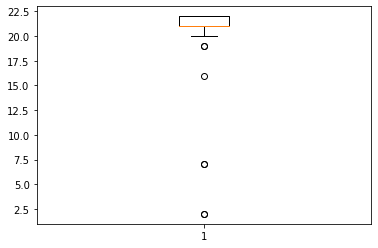

In [12]:
# Distribution of the number of months with data by country.
# Most countries have data for 20-22 months.
df4[df4['level_2'] == 'Covid cases increase> 75% per month'][['sum']].describe().T
plt.boxplot(df4[df4['level_2'] == 'Covid cases increase> 75% per month']['sum'])
plt.show()

Most countries have data for 20-22 months.

To make a more correct analysis we filter only the countries with more than 10 months of data.

In [13]:
# Filter only the count percentage of months with many Covid cases.
# Filter countries with more than 10 months of data.
df5 = df4[df4['level_2'] == 'Covid cases increase> 75% per month']
df5 = df5[df5['sum'] > 10]
# Df ordered, from highest to lowest, by countries with the proportion of months with the highest covid cases.
df5 = df5.drop(['level_2'],axis=1).sort_values(by='perc',ascending=False)

In [14]:
# Distribution of the proportion of months with the highest Covid cases.
df5[['perc']].describe().T

,count,mean,std,min,25%,50%,75%,max
perc,143.0,17.395168,6.540809,4.545,13.636,18.182,22.727,38.095


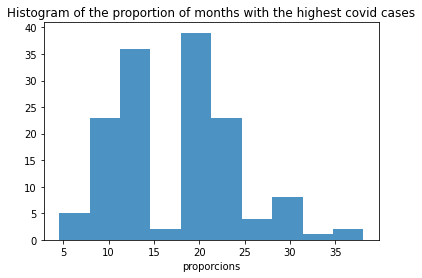

In [15]:
# Histogram of the proportion of months with the highest Covid cases.
plt.hist(df5.perc, alpha = 0.8)
plt.title('Histogram of the proportion of months with the highest covid cases')
plt.xlabel('proporcions')
plt.show()

The asymmetric distribution to the right makes 25% the value that best represents the countries with the highest proportion of months with the highest Covid cases.

### **Which countries are the most affected by the covid month by month?**
### **What category of the HDI Index have the countries most affected by the covid month by month?**

In [16]:
# Extract from the countries most affected by Covid month by month.
df5[df5['perc'] > 25]

,CountryName,hdi_cat,count,sum,perc
209,Papua New Guinea,medium hdi,8,21,38.095
151,Lesotho,low hdi,7,19,36.842
47,Cambodia,medium hdi,7,22,31.818
91,Fiji,high hdi,6,20,30.000
165,Malawi,low hdi,6,20,30.000
294,Zimbabwe,medium hdi,6,21,28.571
235,Sierra Leone,low hdi,6,21,28.571
53,Central African Republic,low hdi,6,21,28.571
185,Myanmar,medium hdi,6,21,28.571
231,Serbia,very high hdi,6,21,28.571


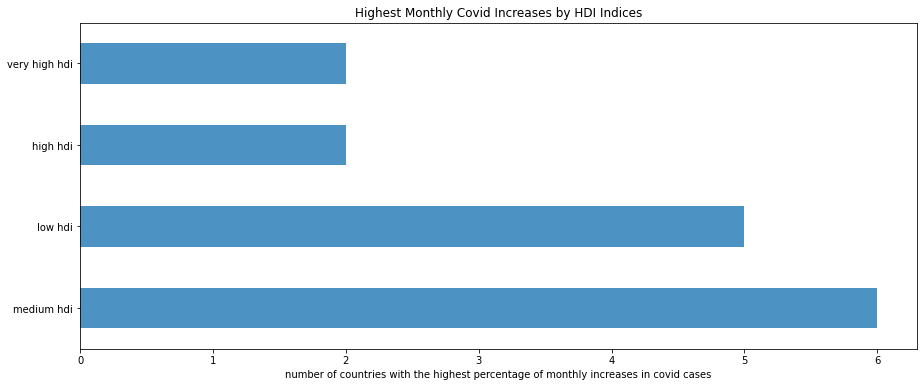

In [17]:
# New df: grouping into HDI categories of the countries most affected by Covid month by month.
cat_inc = df5[df5['perc'] > 25]['hdi_cat'].value_counts()
fig, ax = plt.subplots(figsize=(15,6))
cat_inc.plot(kind='barh',alpha = 0.8)
plt.title('Highest Monthly Covid Increases by HDI Indices')
plt.xlabel('number of countries with the highest percentage of monthly increases in covid cases')
plt.show()

Of the countries most affected by the Covid month by month, more than double have a low and medium HDI Index.

### **Which months have been the most contagious in the world?**

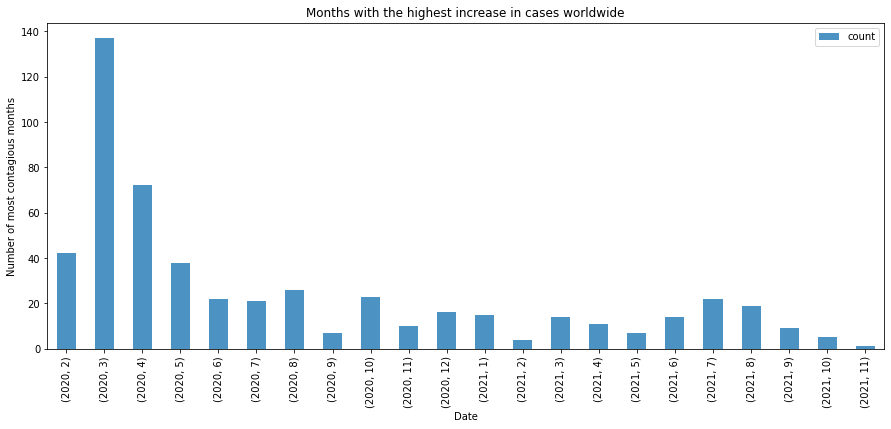

In [18]:
# Filter countries and months with a proportion of increase in cases greater than 75%.
more_cases = high_covid_df[high_covid_df['perc_D_ConfirmedCases'] > 0.75]
# Count, per month, of the highest Covid increments.
contg = more_cases.groupby(['year','month'])['year'].agg(['count'])
fig, ax = plt.subplots(figsize=(15,6))
contg.plot(kind='bar', alpha = 0.8, ax=ax)
plt.title('Months with the highest increase in cases worldwide')
plt.xlabel('Date')
plt.ylabel('Number of most contagious months')
plt.show()

March 2020 was by far the month with the highest peaks of infections in more countries, 137.

07/2021 has been the month with the highest spikes of infections in more countries, 22, followed by August.

## <a name="M2">2. Which countries have experienced more cases of Covid in relation to the population of each country?</a>

In [19]:
# Last date on which there are values for all countries (except one) with covid cases.
date_time_str = '19/11/21'
date_time_obj = datetime.datetime.strptime(date_time_str, '%d/%m/%y')
nulos = sum(df[df['Date'] == date_time_obj]['ConfirmedCases'].isnull())
print(f'There are {nulos} null value of confirmed cases at the earliest date with data.')

There are 1 null value of confirmed cases at the earliest date with data.


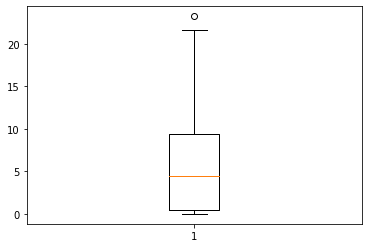

In [20]:
# Selection of total accumulated confirmed Covid cases that appear on the last date with data.
df_maxdate = df[df['Date'] == date_time_obj]
df_maxdate['prop_cases'] = round(df_maxdate['ConfirmedCases'] / df_maxdate['population'] * 100,2)

# Distribution of the proportion of the population infected by country.
plt.boxplot(df_maxdate['prop_cases'].dropna())
plt.show()

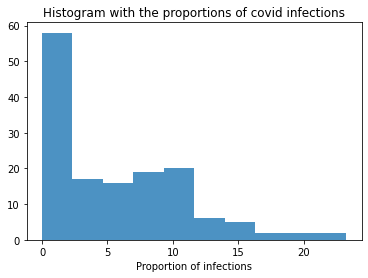

In [21]:
# Histogram with the proportions of Covid infections.
plt.hist(df_maxdate['prop_cases'], alpha = 0.8)
plt.title('Histogram with the proportions of covid infections')
plt.xlabel('Proportion of infections')
plt.show()

The asymmetric distribution to the right makes 12% the value that best represents the countries with the highest proportion of past Covid cases.

A proportion greater than 12 means a population with a high percentage of infections.

In [22]:
# Countries with a very high proportion of past Covid cases.
df_maxdate[df_maxdate['prop_cases'] > 12][['CountryName','ConfirmedCases','2019','hdi_cat','population','prop_cases']]\
                                        .sort_values(by='prop_cases', ascending = False)

,CountryName,ConfirmedCases,2019,hdi_cat,population,prop_cases
89264,Seychelles,22895.0,0.796,high hdi,98462,23.25
35288,Georgia,804571.0,0.812,very high hdi,3714000,21.66
2764,Andorra,16086.0,0.868,very high hdi,77265,20.82
87880,Slovenia,395203.0,0.917,very high hdi,2100126,18.82
85804,Serbia,1228328.0,0.806,very high hdi,6908224,17.78
11068,Bahrain,277322.0,0.852,very high hdi,1701583,16.30
30444,Estonia,216081.0,0.892,very high hdi,1331057,16.23
56740,Lithuania,452268.0,0.882,very high hdi,2794700,16.18
45668,Israel,1339723.0,0.919,very high hdi,9216900,14.54
34596,United Kingdom,9766153.0,0.932,very high hdi,67215293,14.53


In [23]:
# Distribution of the proportion of past Covid cases.
df_maxdate[['prop_cases']].describe().T

,count,mean,std,min,25%,50%,75%,max
prop_cases,147.0,5.591565,5.438443,0.0,0.48,4.49,9.375,23.25


For half of the countries, only 4.5% or less (with a maximum of 4.49%) of their populations have had the virus.
In 75% of the countries, only 9.3% or less of their populations have had the virus.

**All countries, except Seychelles, that have more than 12% of their population with the past virus belong to a very high HDI Index.**

### **What happens to countries with a percentage of their population with past Covid less than 5% (average)?**

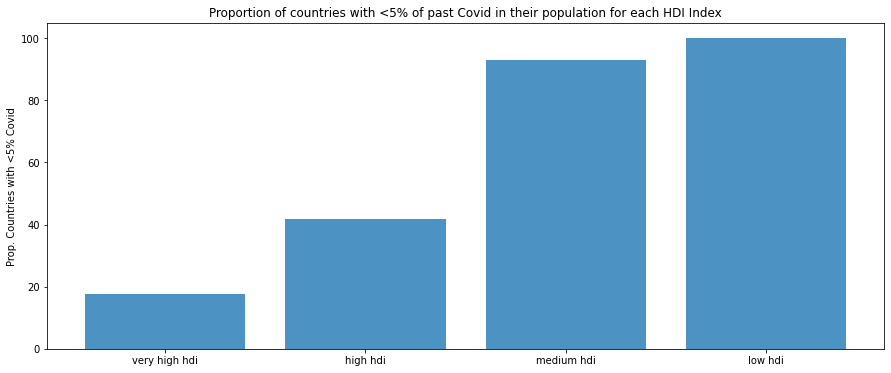

In [24]:
# Number of countries with less than 5% of Covid in their population by category of the HDI Index.
co_less5per_covid = df_maxdate[df_maxdate['prop_cases'] <= 5].groupby(['hdi_cat'])['hdi_cat'].agg(['count']).reset_index()

# Total number of countries by HDI Index category.
prop_co_less5per_covid = df_maxdate.groupby(['hdi_cat'])['hdi_cat'].agg(['count']).reset_index()

# New df: union of the number of total countries and countries with <5% Covid per HDI category.
df6 = pd.merge(co_less5per_covid,prop_co_less5per_covid,on='hdi_cat')
df6.columns = ['hdi_cat','countries <5% with covid cases','n of countries per category']

# New column that shows the proportion of countries with less than 5% of Covid compared to
# Of the total number of countries in each HDI category.
df6['prop countries with less 5% covid'] = round(df6['countries <5% with covid cases']/df6['n of countries per category']*100,2)
df6 = df6.sort_values(by='prop countries with less 5% covid')
fig, ax = plt.subplots(figsize=(15,6))
plt.bar('hdi_cat','prop countries with less 5% covid',data=df6, alpha=0.8)
plt.title('Proportion of countries with <5% of past Covid in their population for each HDI Index')
plt.ylabel('Prop. Countries with <5% Covid')
plt.show()

All the countries with the lowest HDI Index place their population already infected by the virus below 5%.

Almost all countries (92%) with a medium HDI index place their already infected population below 5%.

In [25]:
# Maximum proportion of infections for countries with a low HDI Index.
covid_hdibajo = df_maxdate[df_maxdate['hdi_cat'] == 'low hdi'].prop_cases.max()
print(f'The maximum proportion of countries with a low HDI Index is only {covid_hdibajo}%.')

The maximum proportion of countries with a low HDI Index is only 1.37%.


In [26]:
# Distribution of the percentage of Covid for countries with a very high HDI Index.
df_maxdate[df_maxdate['hdi_cat'] == 'very high hdi'][['prop_cases']].describe().T

,count,mean,std,min,25%,50%,75%,max
prop_cases,57.0,9.887368,4.843781,0.19,7.33,10.24,12.88,21.66


100% of the countries with a low HDI Index have had less than 1.5% of Covid cases in their populations.

Meanwhile, only 17.54% of the countries with a very high HDI Index have had less than 5% of Covid cases in their populations (with its interquartile range between 7.33 and 12.88).


### **What percentage of the world has had the virus?**

In [27]:
# Proportion of the world that has been infected with the virus.
prop_mundial = round(df_maxdate['ConfirmedCases'].sum() / df_maxdate['population'].sum() * 100,2)
print(f'Only {prop_mundial} of the world population (of the countries analyzed) has been infected with Covid.')

Only 3.38 of the world population (of the countries analyzed) has been infected with Covid.


### **Are the countries most affected by the Covid month after month the ones that most of their populations have already infected?**

In [28]:
# Countries most affected by covid month by month.
co_highcovid_monthly = df5[df5['perc'] > 25].CountryName.unique()
print(f'The countries most affected by Covid, month by month, ordered from highest to lowest are:', *co_highcovid_monthly, sep =", ")

The countries most affected by Covid, month by month, ordered from highest to lowest are:, Papua New Guinea, Lesotho, Cambodia, Fiji, Malawi, Zimbabwe, Sierra Leone, Central African Republic, Myanmar, Serbia, Dominica, Israel, Nigeria, Nepal, Timor-Leste


In [29]:
# Proportion of the infected population of the countries most affected by the Covid month by month.
df_maxdate[df_maxdate['CountryName'].isin(co_highcovid_monthly)]\
         .drop(['Date','C1_School closing','D_ConfirmedCases','month','year'],axis = 1)\
         .sort_values(by = 'prop_cases', ascending = False)

,CountryName,ConfirmedCases,2019,hdi_cat,population,prop_cases
85804,Serbia,1228328.0,0.806,very high hdi,6908224,17.78
45668,Israel,1339723.0,0.919,very high hdi,9216900,14.54
26292,Dominica,5589.0,0.742,high hdi,71991,7.76
32520,Fiji,52453.0,0.743,high hdi,896444,5.85
71272,Nepal,818578.0,0.602,medium hdi,29136808,2.81
93416,Timor-Leste,19816.0,0.606,medium hdi,1318442,1.50
56048,Lesotho,21726.0,0.527,low hdi,2142252,1.01
62276,Myanmar,516770.0,0.583,medium hdi,54409794,0.95
102412,Zimbabwe,133593.0,0.571,medium hdi,14862927,0.90
50512,Cambodia,119786.0,0.594,medium hdi,16718971,0.72


Serbia and Israel are among the countries most affected by the Covid month by month and among the countries with a higher proportion of the infected population.

Lesotho, Myanmar, Zimbabwe, Cambodia, Papua, Malawi, Central African Republic, Nigeria and Sierra Leone have almost less than 1% of the population already infected.
However, they are among the countries with the highest increase in Covid cases per month.

### **What happens so that many of the countries (11 of the 15) most affected by Covid every month are among the least infected?**

In [30]:
# Distribution of the number of confirmed cases per month.
df.groupby(['month','year','CountryName'])['D_ConfirmedCases'].agg(['sum']).reset_index()[['sum']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum,3404.0,68600.860165,340361.946057,0.0,201.0,3253.0,26655.0,9010075.0


In [31]:
# Countries most affected by Covid month by month with a very low proportion of infections.
co_paradox_df = df_maxdate[df_maxdate['CountryName'].isin(co_highcovid_monthly)]\
         .drop(['Date','C1_School closing','D_ConfirmedCases','month','year'],axis = 1)\
         .sort_values(by = 'prop_cases', ascending = False)
co_paradox = co_paradox_df[co_paradox_df['prop_cases'] < 2].CountryName.unique()

In [32]:
# If confirmed cases per month are less than the first quantile (201) of the distribution of cases per month, it is assumed
# that confirmed cases for the month are extremely low.
# Condition: Confirmed cases per month <201 are excessively low Covid cases.
condition2 = high_covid_df['D_ConfirmedCases'] < 201
c2 = np.where(condition2, 'Covid cases excessively low', 'Covid cases not excessively low')

# Monthly count of excessively low cases by country.
rec = high_covid_df.groupby(['CountryName','hdi_cat',c2])['D_ConfirmedCases'].agg(['count']).reset_index()
rec = rec[rec['level_2'] == 'Covid cases excessively low'].drop('level_2',axis=1)
# Distribution of the monthly count of excessively low cases in the countries most affected by Covid month by month
# but with a very low contagion rate.
rec[rec['CountryName'].isin(co_paradox)][['count']].describe().T

,count,mean,std,min,25%,50%,75%,max
count,10.0,10.6,4.788876,3.0,7.0,12.0,14.5,17.0


In [33]:
# Distribution of the monthly count of excessively low cases in the rest of the countries.
rec[~rec['CountryName'].isin(co_paradox)][['count']].describe().T

,count,mean,std,min,25%,50%,75%,max
count,138.0,5.384058,5.410617,1.0,2.0,3.0,6.0,23.0


Countries A: countries with large monthly increases in Covid and a very low proportion of the infected population.

Countries B: the rest of the countries.

There is a large difference in the month count with confirmed cases below 201 between countries A and countries B.

Countries A have twice the average (of the count of months with very low cases of Covid) than countries B. That is, countries A have many more months with increases of Covid of very small figures than the rest of the countries.

## <a name="M3">3. In the months with the highest Covid peaks, were the same policies taken in the schools as in the months with the fewest Covid peaks?</a>

In [34]:
# New df: with the number of Covid cases per month and the average of the policy adopted (school closings) per month
# in each country.
pol = df.groupby(['CountryName','hdi_cat','year','month'])\
                .agg({'D_ConfirmedCases':'sum','C1_School closing':'mean'}).reset_index()

# New column with the percentage of the increase in new covid cases each month.
rows_list3 = []
for country in df.CountryName.unique():
    co = pol[pol['CountryName'] == country]
    # new column: percentage of the increase in new covid cases each month.
    co['perc_D_ConfirmedCases'] = round((co['D_ConfirmedCases'] - co['D_ConfirmedCases'].shift())\
                                        /co['D_ConfirmedCases'],3)
    [rows_list3.append(row) for row in co.values]
    
# New df: with the number of covid cases per month, the percentage of increase in new covid cases and
# the average of the policy adopted (closing schools) per month in each country.
df7 = pd.DataFrame(rows_list3, columns = ['CountryName', 'hdi_cat', 'year', 'month','D_ConfirmedCases', 
                                          'C1_School closing','perc_D_ConfirmedCases'])

In [35]:
# Objective: to know for each country which policy has been applied in two different scenarios: when there is
# high increases in Covid compared to the previous month and when those increases are not high.
d_c1 = {}
for country in df7.CountryName.unique():
    co = df7[df7['CountryName'] == country]
    # categorization of percentages into percentages with a high increase and percentages with a normal or low increase.
    co['perc_D_ConfirmedCases'] = co['perc_D_ConfirmedCases']\
                                    .apply(lambda x: 'big increase' if x > 0.75 else 'low increase')
    
    # For each categorization of high case increase and non-high case increase
    # The average of the adopted policy is calculated (school closings).
    # If the two categories of high and non-high case increase exist for the country, they are added in the variables big_inc and low_inc.
    if len(co['perc_D_ConfirmedCases'].unique()) == 2:
        big_inc = round(co.groupby(['perc_D_ConfirmedCases'])['C1_School closing'].agg('mean').values[0],2)
        low_inc = round(co.groupby(['perc_D_ConfirmedCases'])['C1_School closing'].agg('mean').values[1],2)
        d_c1[country] = co['hdi_cat'].unique()[0],big_inc,low_inc
    # If there is only one of the two categories of high or not high case increase for the country, only one of the variables big_inc or low_inc is added.
    elif co['perc_D_ConfirmedCases'].unique().tolist() == ['low increase']:
        low_inc = round(co.groupby(['perc_D_ConfirmedCases'])['C1_School closing'].agg('mean').values[0],2)
        d_c1[country] = co['hdi_cat'].unique()[0],None,low_inc
    else:
        big_inc = round(co.groupby(['perc_D_ConfirmedCases'])['C1_School closing'].agg('mean').values[0],2)
        d_c1[country] = co['hdi_cat'].unique()[0],big_inc,None
        
# Dataframe with the policies (of school closings) in cases with high increases of Covid
# and in cases with low Covid increments.
df_c1 = pd.DataFrame(d_c1).T
df_c1.columns = ['hdi_cat','big_increase','low_increase']
df_c1[['big_increase','low_increase']] = df_c1[['big_increase','low_increase']].apply(pd.to_numeric)
df_c1.sort_values(by=['big_increase','low_increase'],ascending=[False,True])

,hdi_cat,big_increase,low_increase
Indonesia,high hdi,3.00,2.27
China,high hdi,3.00,2.42
Mongolia,high hdi,2.85,2.38
India,medium hdi,2.81,2.18
United States,very high hdi,2.81,2.22
...,...,...,...
Solomon Islands,medium hdi,0.00,0.31
Vanuatu,medium hdi,0.00,0.38
Tonga,high hdi,0.00,0.79
Turkmenistan,high hdi,NaN,0.88


In [36]:
# Know if there are countries that do not have high increases in Covid.
df_c1[df_c1.big_increase.isnull()]

,hdi_cat,big_increase,low_increase
Comoros,medium hdi,NaN,NaN
Turkmenistan,high hdi,NaN,0.88


Turkmenistan has not had large monthly increases in its Covid cases and Comoros is the only country without data.

In [37]:
# Grouping by HDI categories, what value do policies (for school closings) have in both scenarios:
# scenario with high increase in Covid and scenario with not high increase in Covid.
round(df_c1.groupby(['hdi_cat'])['big_increase','low_increase'].mean().sort_values(by='low_increase'),3)

,big_increase,low_increase
hdi_cat,,
low hdi,1.584,1.112
medium hdi,1.823,1.444
very high hdi,1.499,1.614
high hdi,2.116,1.860


In each HDI category, the countries have a more lax application of school closure policies in scenarios with not high increases in Covid.

Countries with low and very high HDI categories have similar closure policies in scenarios with high increases in covid.

### **Have the countries with a proportionally more infected population taken more or less measures to close schools?**

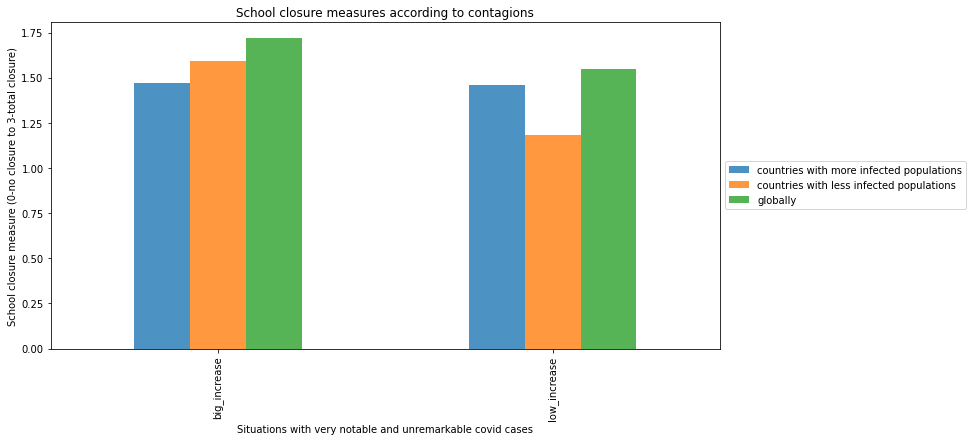

In [39]:
# Countries with the highest proportion of infections.
cont = df_maxdate[df_maxdate['prop_cases'] > 15]
# Average of the policies adopted for situations with very high and not high Covid cases by country
# For countries with the highest proportion of infections.
df_c1_cont = round(df_c1.loc[cont['CountryName'].unique()].mean(),2)

# Countries with the lowest proportion of infections.
notcont = df_maxdate[df_maxdate['prop_cases'] <1]
# Drop Comoros country (index: 19243) for not being in df_c1.
notcont.drop(22140,inplace=True)
# Average of the policies adopted for situations with very high and not high Covid cases by country
# For countries with the lowest proportion of infections.
df_c1_notcont = round(df_c1.loc[notcont['CountryName'].unique()].mean(),2)

# Average of the policies adopted for situations with very high Covid cases
# And not high per country on average worldwide.
df_c1_g = pd.Series([round(df_c1.big_increase.mean(),2), round(df_c1.low_increase.mean(),2)],index=['big_increase','low_increase'])

# New df: with the policy averages for situations with a large increase in Covid and not a large increase
# with countries with the highest proportion of infections, countries with the lowest proportion of infections and total number of countries.
df_c1_ = pd.concat([df_c1_cont, df_c1_notcont, df_c1_g], axis=1)
df_c1_.columns = ['countries with more infected populations', 'countries with less infected populations', 'globally']
fig, ax = plt.subplots(figsize=(15,6))
df_c1_.plot(kind='bar',alpha=0.80, ax=ax)
# Shrink current axis by 20%.
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis.
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('School closure measures according to contagions')
plt.xlabel('Situations with very notable and unremarkable covid cases')
plt.ylabel('School closure measure (0-no closure to 3-total closure)')
plt.show()

Globally, a few more measures are taken when the scenarios are more contagious, although the difference is not notable.

Restrictive policies, consisting of significant alterations and the closure of some levels, are those that remain more constant over time.

Countries with a less infected population have taken a few more measures than countries with the most infections in the months with high infections.
However, the opposite occurs in months with fewer infections: the most infected populations take a few more actions than the least infected populations.

# Conclusions
* Of the countries most affected by the Covid month by month, more than double have a low and medium HDI Index.
* March 2020 was by far the month with the highest spikes in infections in more countries.
* 100% of the countries with a low HDI Index have had less than 1.5% of Covid cases in their populations.
* In 75% of countries, only 9.3% or less of their populations have had the virus.
* Only 3.38% of the world population (of the countries analyzed) has been infected with Covid.
* Countries with low and very high HDI categories have similar closure policies in scenarios with high increases in Covid.
* Restrictive policies, consisting of significant alterations and closure of some levels (level 1), are those that remain more constant over time.